In [76]:
import os
from dotenv import load_dotenv

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    precision_score, 
    recall_score,
    confusion_matrix,
    log_loss)

In [62]:
TABLE_NAME = 'users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_fio'
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'churn_model_maximpetrov'
FS_ASSETS = "fs_assets" 

In [68]:
mlflow.set_tracking_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')
mlflow.set_registry_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')

In [4]:
load_dotenv()

True

In [30]:
connection = {'sslmode' : 'require', 'target_session_attrs' : 'read-write'}

postgres_credetials = {
    'dbname' : os.getenv('DB_DESTINATION_NAME'),
    'host' : os.getenv('DB_DESTINATION_HOST'),
    'port' : os.getenv('DB_DESTINATION_PORT'),
    'user' : os.getenv('DB_DESTINATION_USER'),
    'password' : os.getenv('DB_DESTINATION_PASSWORD'),
}

connection.update(postgres_credetials)

In [44]:
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f'SELECT * FROM {TABLE_NAME}')
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

        df = pd.DataFrame(data, columns=columns)

In [45]:
columns_without_datetime = df.select_dtypes(exclude='datetime').columns
df = df.dropna(subset=columns_without_datetime)
y = df['target']

In [46]:
model_uri = 's3://s3-student-mle-20241219-a60d0b01a0/4/24906d24e7e74b5da4a8b81daca6e18c/artifacts/column_transformer'

preprocessor = mlflow.sklearn.load_model(model_uri)
encoded_features = preprocessor.fit_transform(df)
df = pd.DataFrame(encoded_features, columns=preprocessor.get_feature_names_out())

In [47]:
X = df

In [48]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp)

In [49]:
estimator = RandomForestClassifier(n_estimators=300, n_jobs=-1)

sfs = SFS(
    estimator=estimator,
    floating=False,
    forward=True,
    k_features=10,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

sbs = SFS(
    estimator=estimator,
    floating=False,
    forward=False,
    k_features=10,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

sfs.fit(X_train, y_train)
top_sfs = list(sfs.k_feature_names_)

# Запуск SBS
sbs.fit(X_train, y_train)
top_sbs = list(sbs.k_feature_names_)

In [51]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [53]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

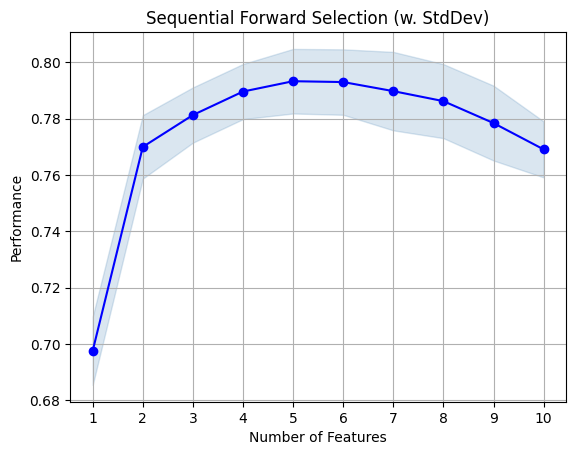

<Figure size 640x480 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png")

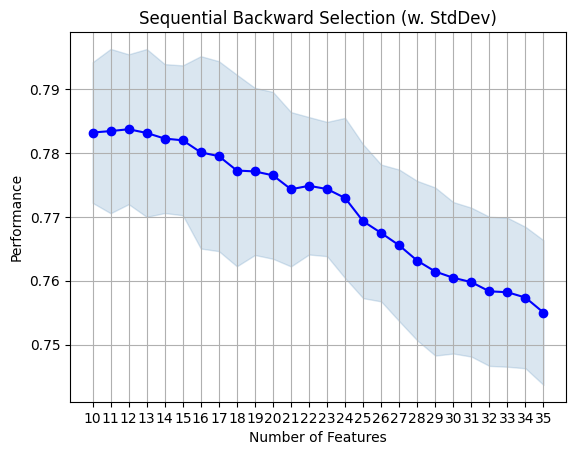

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png")

In [57]:
interc_features = list(set(top_sbs) & set(top_sfs))# ваш код здесь #
union_features = list(set(top_sbs) | set(top_sfs))# ваш код здесь #

In [69]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS)

In [103]:
model_interc = LogisticRegression()
model_union = LogisticRegression()

In [104]:
model_interc.fit(X_train[interc_features], y_train)
model_union.fit(X_train[union_features], y_train)

LogisticRegression()

In [105]:
interc_prediction = model_interc.predict(X_test[interc_features])
interc_proba = model_interc.predict_proba(X_test[interc_features])[:, 1]

union_prediction = model_union.predict(X_test[union_features])
union_proba = model_union.predict_proba(X_test[union_features])[:, 1]

In [107]:
union_metrics = {}

_, err1, _, err2 = confusion_matrix(y_test, union_prediction, normalize='all').ravel()
auc = roc_auc_score(y_test, union_proba)
precision = precision_score(y_test, union_prediction)
recall = recall_score(y_test, union_prediction)
f1 = f1_score(y_test, union_prediction)
logloss = log_loss(y_test, union_prediction)

union_metrics["err1"] = err1
union_metrics["err2"] = err2
union_metrics["auc"] = auc
union_metrics["precision"] = precision
union_metrics["recall"] = recall
union_metrics["f1"] = f1
union_metrics["logloss"] = logloss

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
interc_metrics = {}

_, err1, _, err2 = confusion_matrix(y_test, interc_prediction, normalize='all').ravel()
auc = roc_auc_score(y_test, interc_proba)
precision = precision_score(y_test, interc_prediction)
recall = recall_score(y_test, interc_prediction)
f1 = f1_score(y_test, interc_prediction)
logloss = log_loss(y_test, interc_prediction)

interc_metrics["err1"] = err1
interc_metrics["err2"] = err2
interc_metrics["auc"] = auc
interc_metrics["precision"] = precision
interc_metrics["recall"] = recall
interc_metrics["f1"] = f1
interc_metrics["logloss"] = logloss

In [122]:
EXPERIMENT_NAME = 'feature_selection_intersection'

In [125]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    experiment_id = experiment.experiment_id
else:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [126]:
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_train[interc_features], model_interc.predict(X_train[interc_features]))
input_example = X_train[interc_features].iloc[:1].to_dict(orient="records")
metadata = {
    "model_type": "LogisticRegression",
    "task": "binary_classification"
    }

In [127]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(interc_metrics)

    model_info = mlflow.sklearn.log_model(
    sk_model=model_interc,
    pip_requirements=pip_requirements,        
    signature=signature,
    input_example=input_example,
    metadata=metadata,
    artifact_path="models",
    registered_model_name=REGISTRY_MODEL_NAME,
    await_registration_for=60
    )

Registered model 'churn_model_maximpetrov' already exists. Creating a new version of this model...
2025/02/11 07:56:21 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_maximpetrov, version 14
Created version '14' of model 'churn_model_maximpetrov'.


In [128]:
run_id

'61b492b0896e44c288b05eef994b23fc'

In [131]:
EXPERIMENT_NAME = 'feature_selection_union'

In [132]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    experiment_id = experiment.experiment_id
else:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

In [133]:
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_train[union_features], model_union.predict(X_train[union_features]))
input_example = X_train[union_features].iloc[:1].to_dict(orient="records")
metadata = {
    "model_type": "LogisticRegression",
    "task": "binary_classification"
    }

In [134]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(union_metrics)

    model_info = mlflow.sklearn.log_model(
    sk_model=model_union,
    pip_requirements=pip_requirements,        
    signature=signature,
    input_example=input_example,
    metadata=metadata,
    artifact_path="models",
    registered_model_name=REGISTRY_MODEL_NAME,
    await_registration_for=60
    )

Registered model 'churn_model_maximpetrov' already exists. Creating a new version of this model...
2025/02/11 07:57:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_maximpetrov, version 15
Created version '15' of model 'churn_model_maximpetrov'.


In [135]:
run_id

'bf4af8a63c7c420688283a290c6d2024'